In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import gc

from helpers import plot_class
from helpers import helpfunction as helper

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

In [49]:
# should return resolution per bin
per1 = 50 - 45  # 68.27/2            # 1sigma stat boundaries
per2 = 50 + 45  # 68.27/2
per21 = 50 - 95.45 / 2
per22 = 50 + 95.45 / 2
persig1 = 50 - 68.27 / 2
persig2 = 50 + 68.27 / 2


def getResolution(data_x, data_y, x_edges, ax, periodic=False):
    mean = []
    err = []
    percentiles_arr = []

    mids = 0.5 * (x_edges[1:] + x_edges[:-1])
    bin_id = np.digitize(data_x, x_edges)
    data_diff = data_y - data_x  # / data_x
    if periodic:
        data_diff = (data_diff + np.pi) % (2 * np.pi) - np.pi
        data_diff *= 180 / np.pi
        mids *= 180 / np.pi
    for i in range(1, len(x_edges)):
        ax.hist(
            data_diff[bin_id == i],
            bins=50,
            range=np.percentile(data_diff, [per21, per22]),
            histtype="step",
        )
        percentiles = np.percentile(
            data_diff[bin_id == i], [per1, persig1, 50, persig2, per2]
        )
        print(
            round(10 * mids[i - 1]) / 10,
            "\t",
            np.median(data_y[bin_id == i]),
            "\t",
            percentiles[[0, 2, 4]],
            "\t",
            (percentiles[-1] - percentiles[0]) / 2,
        )
        if periodic:
            percentiles /= 180 / np.pi
            mean.append(mids[i - 1] / (180 / np.pi) + percentiles[2])
        else:
            mean.append(mids[i - 1] + percentiles[2])
        err.append([percentiles[2] - percentiles[0], percentiles[4] - percentiles[2]])
        percentiles_arr.append(percentiles)
    if periodic:
        mids /= 180 / np.pi
    quants = np.array(percentiles_arr).T
    return mids, mean, err, quants

<IPython.core.display.Javascript object>

In [5]:
run = 3
input_dir = "./input/16Jan/"
output_dir = "./output/run{}/".format(run)

<IPython.core.display.Javascript object>

In [6]:
data = pickle.load(open(input_dir + "run{}_slimmed.pckl".format(run), "rb"))
samples = ["nu", "nue", "on", "off", "dirt"]
title_str = "MicroBooNE Run{}: {:.1e} POT".format(run, data["on"]["pot"])

<IPython.core.display.Javascript object>

In [7]:
for s in list(data.keys()):
    if s not in samples:
        del data[s]
gc.collect()

3426

<IPython.core.display.Javascript object>

In [8]:
q_muon_select = "(trk_llr_pid_score_v>0.2 & trk_score_v>0.8 & trk_len_v>10 & pfp_generation_v==2 & trk_distance_v<4)"
q_event_select = "(reco_fid_vol & muon_candidate  & CosmicIP>20 & slpdg==14 & topological_score>0.1 & all_start_contained)"
q_preselect_tracks = "(reco_fid_vol & trk_score_v>0.8 & trk_len_v>20 & pfp_generation_v==2 & trk_distance_v<4 & CosmicIP>20 & slpdg==14 & all_start_contained)"
q_crt = "(~(crtveto & crthitpe>100) & _closestNuCosmicDist>5 & all_end_contained)"
q_event_select += " & " + q_crt

<IPython.core.display.Javascript object>

In [9]:
fields = list(data["nu"]["daughters"].keys())
[f for f in fields if "range" in f]

['trk_range_muon_mom_v']

<IPython.core.display.Javascript object>

In [10]:
for k, v in data.items():
    # Fill in default for missing field if no CRT data
    if "_closestNuCosmicDist" not in v["daughters"]:
        v["daughters"]["_closestNuCosmicDist"] = 999

    # Number of tracks at vertex
    v["daughters"]["track_at_vtx"] = v["daughters"].eval(
        "trk_distance_v<3 & trk_distance_v>=0 & trk_score_v>0.3"
    )
    v["daughters"]["track_at_vtx"] = (
        v["daughters"]["track_at_vtx"].groupby("event").transform(sum)
    )

    # Add fiducial and containnment fields
    v["daughters"]["reco_fid_vol"] = np.repeat(
        helper.is_fid(
            *v["daughters"][
                ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
            ]
            .xs(0, level="daughter")
            .values.T
        ),
        v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )

    muon_candidate = v["daughters"].eval(q_muon_select)
    muon_cand_maxll = (
        v["daughters"][muon_candidate]["trk_llr_pid_score_v"]
        .groupby("event")
        .transform(max)
        == v["daughters"][muon_candidate]["trk_llr_pid_score_v"]
    )
    v["daughters"]["muon_candidate"] = False
    v["daughters"].loc[
        muon_cand_maxll[muon_cand_maxll == True].index, "muon_candidate"
    ] = True

    end_mask = helper.is_contain(
        v["daughters"]["trk_sce_end_x_v"],
        v["daughters"]["trk_sce_end_y_v"],
        v["daughters"]["trk_sce_end_z_v"],
    )
    start_mask = helper.is_contain(
        v["daughters"]["trk_sce_start_x_v"],
        v["daughters"]["trk_sce_start_y_v"],
        v["daughters"]["trk_sce_start_z_v"],
    )
    v["daughters"]["all_start_contained"] = start_mask
    v["daughters"]["all_start_contained"] = (
        v["daughters"]["all_start_contained"].groupby("event").transform(min)
    )
    v["daughters"]["all_end_contained"] = end_mask
    v["daughters"]["all_end_contained"] = (
        v["daughters"]["all_end_contained"].groupby("event").transform(min)
    )

    ### Range based energy sum
    v["daughters"].loc[muon_candidate, "range_based_tot_energy"] = np.sqrt(
        v["daughters"]["trk_range_muon_mom_v"] ** 2 + 0.106 ** 2
    )
    v["daughters"].loc[
        ((v["daughters"]["trk_score_v"] > 0.5) & muon_candidate == False),
        "range_based_tot_energy",
    ] = v["daughters"]["trk_energy_proton_v"]

    # shower energy should not be negative
    v["daughters"].loc[v["daughters"]["shr_energy_y_v"] < 0, "shr_energy_y_v"] = 0
    v["daughters"].loc[
        v["daughters"]["trk_score_v"] <= 0.5, "range_based_tot_energy"
    ] = (v["daughters"]["shr_energy_y_v"] / 1000 / 0.7)
    v["daughters"]["range_based_tot_energy"] = (
        v["daughters"]["range_based_tot_energy"].groupby("event").transform(sum)
    )
    ####

    # This code defines a containment of all other objects except of the muon.
    v["daughters"]["non_muon_end_contained"] = end_mask
    v["daughters"].loc[
        muon_cand_maxll[muon_cand_maxll == True].index, "non_muon_end_contained"
    ] = True
    v["daughters"]["non_muon_end_contained"] = (
        v["daughters"]["non_muon_end_contained"].groupby("event").transform(min)
    )

    # Muon selection
    v["daughters"]["numuccinc"] = v["daughters"].eval(q_event_select)
    v["daughters"]["numuccinc_crt"] = (
        v["daughters"].eval(q_crt) * v["daughters"]["numuccinc"]
    )

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


<IPython.core.display.Javascript object>

In [11]:
data["nu"]["mc"].keys()

dict_keys(['mc_pdg', 'mc_E', 'lep_e', 'ccnc', 'theta', 'true_nu_vtx_x', 'true_nu_vtx_y', 'true_nu_vtx_z', 'n_pfps', 'interaction', 'weightSpline', 'weightSplineTimesTune', 'leeweight', 'category', 'nu_e', 'nu_pdg', 'nelec', 'npion', 'npi0', 'nproton', 'nmuon', 'nu_completeness_from_pfp', 'nu_purity_from_pfp', 'nueccinc', 'true_category'])

<IPython.core.display.Javascript object>

In [12]:
# Fix weighting problems:
data["nu"]["mc"]["weightSplineTimesTune"] = np.nan_to_num(
    data["nu"]["mc"]["weightSplineTimesTune"]
)
data["nu"]["daughters"]["weightSplineTimesTune"] = np.nan_to_num(
    data["nu"]["daughters"]["weightSplineTimesTune"]
)

<IPython.core.display.Javascript object>

In [13]:
nu_keys_true = [
    "nu_pdg",
    "nu_e",
    "lep_e",
    "true_nu_vtx_x",
    "true_nu_vtx_y",
    "true_nu_vtx_z",
    "nmuon",
    "nproton",
    "npi0",
    "npion",
    "interaction",
    "weightSplineTimesTune",
]
nu_df = pd.DataFrame({k: data["nu"]["mc"][k] for k in nu_keys_true})

<IPython.core.display.Javascript object>

In [14]:
nu_df.head()

,nu_pdg,nu_e,lep_e,true_nu_vtx_x,true_nu_vtx_y,true_nu_vtx_z,nmuon,nproton,npi0,npion,interaction,weightSplineTimesTune
0,14,0.921558,0.472798,170.053543,-166.923111,641.638794,1,1,0,0,0,1.223253
1,14,1.542911,1.459876,130.683121,-90.336731,1007.534973,1,0,0,0,0,1.714393
2,14,0.809162,0.266983,71.724678,59.703136,543.274109,0,2,0,0,1,1.000000
3,14,2.829593,2.650885,197.442490,-24.961420,217.803497,0,0,0,0,0,1.000000
4,14,0.961612,0.581974,181.283936,2.800097,1099.654907,1,2,0,0,1,1.000000


<IPython.core.display.Javascript object>

In [15]:
nu_df["true_vtx_fid"] = helper.is_fid(
    data["nu"]["mc"]["true_nu_vtx_x"],
    data["nu"]["mc"]["true_nu_vtx_y"],
    data["nu"]["mc"]["true_nu_vtx_z"],
)

<IPython.core.display.Javascript object>

In [16]:
q_30 = "abs(nu_pdg)==14 & nmuon==1 & nproton==0 & (npi0+npion)==0 & true_vtx_fid"
q_31 = "abs(nu_pdg)==14 & nmuon==1 & nproton>0 & (npi0+npion)==0 & true_vtx_fid"
q_32 = "abs(nu_pdg)==14 & nmuon==1 & (npi0+npion)>0 & true_vtx_fid"
q_33 = "abs(nu_pdg)==14 & nmuon==0 & true_vtx_fid"
q_10 = "abs(nu_pdg)==12 & true_vtx_fid"
q_5 = "true_vtx_fid==0"
new_cat = (
    nu_df.eval(q_30) * 30
    + nu_df.eval(q_31) * 31
    + nu_df.eval(q_32) * 32
    + nu_df.eval(q_33) * 33
    + nu_df.eval(q_10) * 10
    + nu_df.eval(q_5) * 5
)
nu_df["category"] = new_cat

<IPython.core.display.Javascript object>

In [17]:
# Do not use the fid vol of the analyser at all
q_30 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & nproton==0 & (npi0+npion)==0"
q_31 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & nproton>0 & (npi0+npion)==0"
q_32 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & (npi0+npion)>0"
q_33 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==0"
q_10 = "true_fid_vol & abs(nu_pdg)==12"
q_5 = "true_fid_vol==0"

for k, v in data.items():
    if k not in helper.data_samples:

        v["daughters"]["true_fid_vol"] = np.repeat(
            helper.is_fid(
                *v["daughters"][["true_nu_vtx_x", "true_nu_vtx_y", "true_nu_vtx_z"]]
                .xs(0, level="daughter")
                .values.T
            ),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )

        new_cat = (
            v["daughters"].eval(q_30) * 30
            + v["daughters"].eval(q_31) * 31
            + v["daughters"].eval(q_32) * 32
            + v["daughters"].eval(q_33) * 33
            + v["daughters"].eval(q_10) * 10
            + v["daughters"].eval(q_5) * 5
        )
        v["daughters"]["category"] = new_cat
        cosmic = (v["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            v["daughters"]["category"] != 5
        )
        v["daughters"].loc[cosmic, "category"] = 4

<IPython.core.display.Javascript object>

In [18]:
q_30 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & (interaction==0 | interaction==5)"
q_31 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & (interaction==1 | interaction==3)"
q_32 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & interaction==2"
q_310 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & interaction==10"
q_33 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==0"
q_10 = "true_fid_vol & abs(nu_pdg)==12"
q_5 = "true_fid_vol==0"

for k, v in data.items():
    if k not in helper.data_samples:
        new_cat = (
            v["daughters"].eval(q_30) * 30
            + v["daughters"].eval(q_31) * 31
            + v["daughters"].eval(q_32) * 32
            + v["daughters"].eval(q_310) * 310
            + v["daughters"].eval(q_33) * 33
            + v["daughters"].eval(q_10) * 10
            + v["daughters"].eval(q_5) * 5
        )
        v["daughters"]["cat_int"] = new_cat
        cosmic = (v["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            v["daughters"]["cat_int"] != 5
        )
        v["daughters"].loc[cosmic, "cat_int"] = 4

        # Add the modified purity/completeness to account for overlay.
        overlay_mask = v["daughters"].eval(
            "backtracked_overlay_purity>backtracked_purity"
        )
        v["daughters"].loc[overlay_mask, "backtracked_pdg"] = 0
        v["daughters"].loc[overlay_mask, "backtracked_purity"] = v["daughters"].loc[
            overlay_mask, "backtracked_overlay_purity"
        ]
        v["daughters"].loc[overlay_mask, "backtracked_completeness"] = 0

<IPython.core.display.Javascript object>

In [19]:
print(data["nu"]["daughters"].query("numuccinc")["category"].value_counts())
print(data["nu"]["daughters"].query("numuccinc")["cat_int"].value_counts())
print(nu_df["interaction"].value_counts())
print(sum(data["on"]["daughters"].eval("numuccinc")))

31    25540
32    13507
30     5996
33     4618
5      2654
4      1803
10      100
Name: category, dtype: int64
30     19036
31     16909
310     6443
33      4618
32      2655
5       2654
4       1803
10       100
Name: cat_int, dtype: int64
0     508430
1     355593
10    109323
2      88033
3       2579
5         70
Name: interaction, dtype: int64
494


<IPython.core.display.Javascript object>

In [20]:
sum(
    data["nu"]["daughters"].query("numuccinc & category>29 & category<33")[
        "weightSplineTimesTune"
    ]
) / sum(nu_df.query("category>29 & category<33")["weightSplineTimesTune"])

0.17534776295732335

<IPython.core.display.Javascript object>

In [21]:
np.isnan(data["nu"]["daughters"]["weightSplineTimesTune"]).any()

False

<IPython.core.display.Javascript object>

97.7134


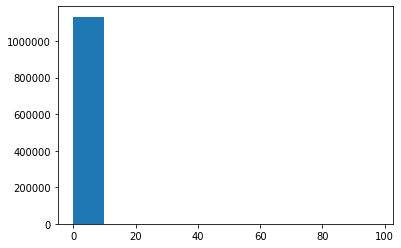

<IPython.core.display.Javascript object>

In [22]:
plt.hist(data["nu"]["daughters"]["weightSplineTimesTune"])
print(max(data["nu"]["mc"]["weightSplineTimesTune"]))

## Plots

In [23]:
# Load the plotting module
plotter = plot_class.Plotter(data, signal="numu", genie_version="mcc9.1")

Using the spline weights as in MCC9.1 Genie V3 tune 1
Initialisation completed!


<IPython.core.display.Javascript object>

0 26466.813195705414 167396.89274004102 15.810815100855574
10 9911.103831350803 46158.21458798647 21.472025986746793
1 16756.0 84900.0 19.736160188457006


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:464: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h


2 2655.0 20023.0 13.259751286021077


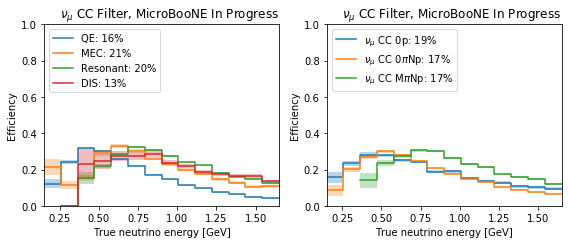

<IPython.core.display.Javascript object>

In [24]:
# eff per mode
cats = [0, 1, 2, 10]
field = "nu_e"
x_min = 0.15
x_max = 1.65
n_bins = 15
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))


cats = [0, 10, 1, 2]
for cat in cats:
    num = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("interaction==@cat")[field]
    )
    den = nu_df.query("category>29 & category<33").query("interaction==@cat")[field]
    num_w = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("interaction==@cat")["weightSplineTimesTune"]
    )
    den_w = nu_df.query("category>29 & category<33").query("interaction==@cat")[
        "weightSplineTimesTune"
    ]

    print(cat, sum(num_w), sum(den_w), sum(num_w) / sum(den_w) * 100)
    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[0].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[0].step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plotter.dicts.int_labels_true[cat], sum(num_w) / sum(den_w) * 100
        ),
    )
ax[0].set_title(r"$\nu_\mu$ CC Filter, MicroBooNE In Progress", loc="right")
ax[0].set_xlabel("True neutrino energy [GeV]")
ax[0].set_ylabel("Efficiency")
ax[0].set_ylim(0, 1)
ax[0].set_xlim(x_min, x_max)
ax[0].legend(loc="upper left")


cats = [30, 31, 32]
for cat in cats:
    num = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("category==@cat")[field]
    )
    den = nu_df.query("category>29 & category<33").query("category==@cat")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("category==@cat")["weightSplineTimesTune"]
    )
    den_w = nu_df.query("category>29 & category<33").query("category==@cat")[
        "weightSplineTimesTune"
    ]
    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[1].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[1].step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plotter.dicts.category_labels[cat], sum(num_w) / sum(den_w) * 100
        ),
    )
ax[1].set_title(r"$\nu_\mu$ CC Filter, MicroBooNE In Progress", loc="right")
ax[1].set_xlabel("True neutrino energy [GeV]")
ax[1].set_ylabel("Efficiency")
ax[1].set_ylim(0, 1)
ax[1].set_xlim(x_min, x_max)
ax[1].legend(loc="upper left")

fig.tight_layout()
fig.savefig(output_dir + "numu_efficiency_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 171. 	#entries 19036
MC category: Resonant: 109. 	#entries 16909
MC category: DIS: 17. 	#entries 2655
MC category: MEC: 64. 	#entries 6443
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


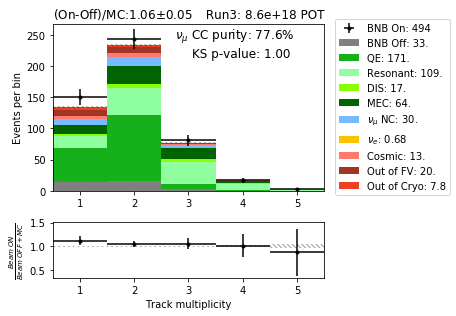

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "track_at_vtx",
    "Track multiplicity",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_vtxntrack_int_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: $\nu_\mu$ CC 0p: 54. 	#entries 5996
MC category: $\nu_\mu$ CC 0$\pi$Np: 220. 	#entries 25540
MC category: $\nu_\mu$ CC M$\pi$Np: 88. 	#entries 13507
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


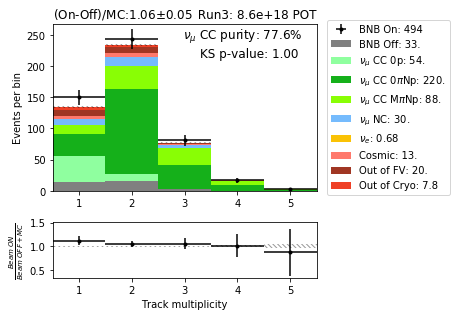

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "track_at_vtx",
    "Track multiplicity",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.95,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_vtxntrack_cat_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 171. 	#entries 19036
MC category: Resonant: 109. 	#entries 16909
MC category: DIS: 17. 	#entries 2655
MC category: MEC: 64. 	#entries 6443
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


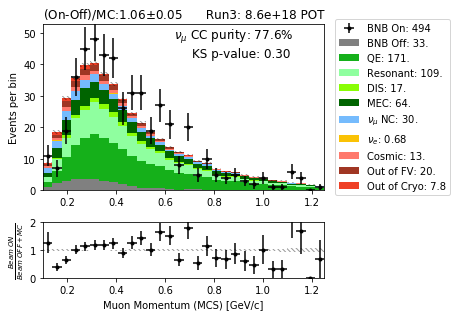

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "trk_mcs_muon_mom_v",
    "Muon Momentum (MCS) [GeV/c]",
    N_bins=30,
    x_min=0.1,
    x_max=1.25,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_mcsmom_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 171. 	#entries 19036
MC category: Resonant: 109. 	#entries 16909
MC category: DIS: 17. 	#entries 2655
MC category: MEC: 64. 	#entries 6443
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:313: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyt

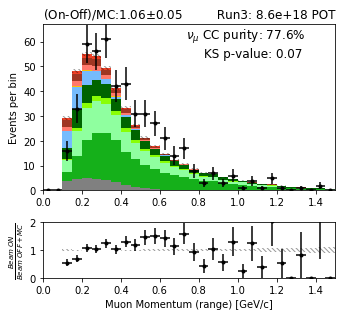

<IPython.core.display.Javascript object>

In [51]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "trk_range_muon_mom_v",
    "Muon Momentum (range) [GeV/c]",
    N_bins=30,
    x_min=0.0,
    x_max=1.5,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_rangemom_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 171. 	#entries 19036
MC category: Resonant: 109. 	#entries 16909
MC category: DIS: 17. 	#entries 2655
MC category: MEC: 64. 	#entries 6443
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


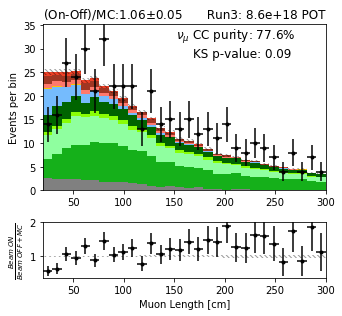

<IPython.core.display.Javascript object>

In [29]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "trk_len_v",
    "Muon Length [cm]",
    N_bins=30,
    x_min=20,
    x_max=300,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_trklen_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 171. 	#entries 19036
MC category: Resonant: 109. 	#entries 16909
MC category: DIS: 17. 	#entries 2655
MC category: MEC: 64. 	#entries 6443
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


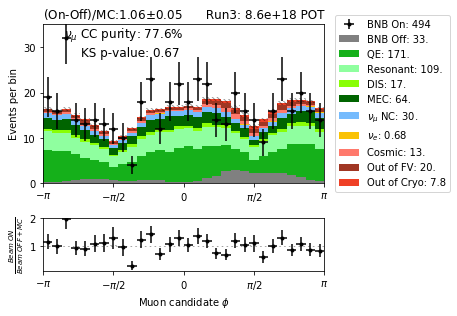

<IPython.core.display.Javascript object>

In [30]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "trk_phi_v",
    r"Muon candidate $\phi$",
    N_bins=30,
    x_min=-np.pi,
    x_max=np.pi,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.0,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(output_dir + "data_mc/numu_phi_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 171. 	#entries 19036
MC category: Resonant: 109. 	#entries 16909
MC category: DIS: 17. 	#entries 2655
MC category: MEC: 64. 	#entries 6443
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


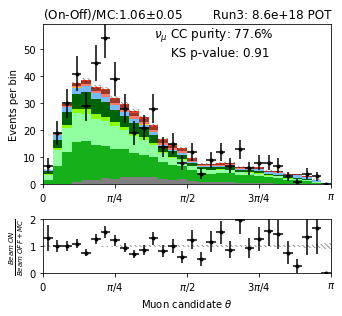

<IPython.core.display.Javascript object>

In [31]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "trk_theta_v",
    r"Muon candidate $\theta$",
    N_bins=30,
    x_min=0,
    x_max=np.pi,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.8,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_theta_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: $\nu_\mu$ CC 0p: 177. 	#entries 20685
MC category: $\nu_\mu$ CC 0$\pi$Np: 1055. 	#entries 130121
MC category: $\nu_\mu$ CC M$\pi$Np: 412. 	#entries 63128
MC category: $\nu_\mu$ NC: 107. 	#entries 16492
MC category: $\nu_e$: 2.3 	#entries 11094
MC category: Cosmic: 97. 	#entries 15401
MC category: Out of FV: 244. 	#entries 33563
MC category: Out of Cryo: 127. 	#entries 4034
MC category: No slice: 0.0065 	#entries 1


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: $p$: 439. 	#entries 63666
MC category: $\mu$: 1295. 	#entries 161092
MC category: $e$: 0.37 	#entries 2376
MC category: $\pi^{\pm}$: 125. 	#entries 21903
MC category: $\gamma$: 2.3 	#entries 396
MC category: $K$: 0.67 	#entries 138
MC category: Cosmic: 357. 	#entries 44948


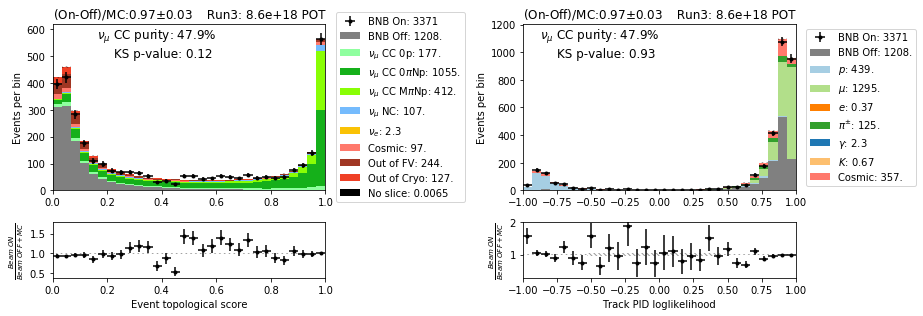

<IPython.core.display.Javascript object>

In [32]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "topological_score",
    r"Event topological score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query=q_preselect_tracks,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.6,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][0]

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_llr_pid_score_v",
    r"Track PID loglikelihood",
    N_bins=30,
    x_min=-1,
    x_max=1,
    query=q_preselect_tracks,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.0,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)


fig.tight_layout()
fig.savefig(output_dir + "data_mc/numu_pret_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 171. 	#entries 19036
MC category: Resonant: 109. 	#entries 16909
MC category: DIS: 17. 	#entries 2655
MC category: MEC: 64. 	#entries 6443
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


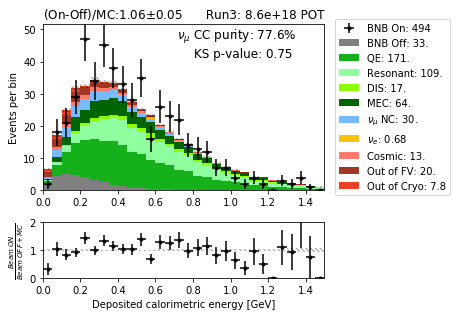

<IPython.core.display.Javascript object>

In [33]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "NeutrinoEnergy2/1000",
    "Deposited calorimetric energy [GeV]",
    N_bins=30,
    x_min=0,
    x_max=1.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_caloe_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 171. 	#entries 19036
MC category: Resonant: 109. 	#entries 16909
MC category: DIS: 17. 	#entries 2655
MC category: MEC: 64. 	#entries 6443
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:313: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyt

MC category: QE: 171. 	#entries 19036
MC category: Resonant: 109. 	#entries 16909
MC category: DIS: 17. 	#entries 2655
MC category: MEC: 64. 	#entries 6443
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


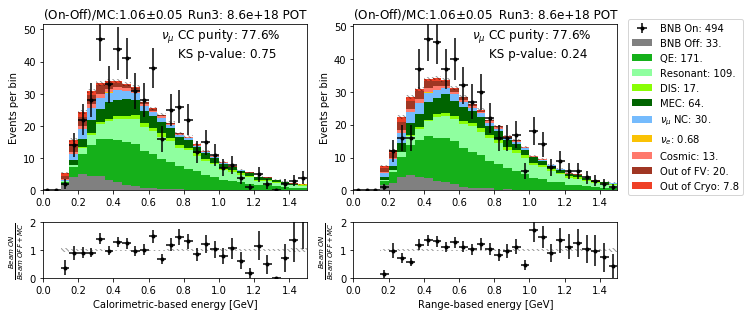

<IPython.core.display.Javascript object>

In [34]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(6.5 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "NeutrinoEnergy2/1000+0.106",
    "Calorimetric-based energy [GeV]",
    N_bins=30,
    x_min=0,
    x_max=1.5,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.9,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "range_based_tot_energy",
    "Range-based energy [GeV]",
    N_bins=30,
    x_min=0,
    x_max=1.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.9,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_caloe_rangevscalo_run{}.pdf".format(run),
    bbox_inches="tight",
)

MC category: $\nu_\mu$ CC 0p: 54. 	#entries 5996
MC category: $\nu_\mu$ CC 0$\pi$Np: 220. 	#entries 25540
MC category: $\nu_\mu$ CC M$\pi$Np: 88. 	#entries 13507
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: $\nu_\mu$ CC 0p: 54. 	#entries 5996
MC category: $\nu_\mu$ CC 0$\pi$Np: 220. 	#entries 25540
MC category: $\nu_\mu$ CC M$\pi$Np: 88. 	#entries 13507
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250
MC category: $\nu_\mu$ CC 0p: 54. 	#entries 5996
MC category: $\nu_\mu$ CC 0$\pi$Np: 220. 	#entries 25540
MC category: $\nu_\mu$ CC M$\pi$Np: 88. 	#entries 13507
MC category: $\nu_\mu$ NC: 30. 	#entries 4618
MC category: $\nu_e$: 0.68 	#entries 3221
MC category: Cosmic: 13. 	#entries 2104
MC category: Out of FV: 20. 	#entries 2758
MC category: Out of Cryo: 7.8 	#entries 250


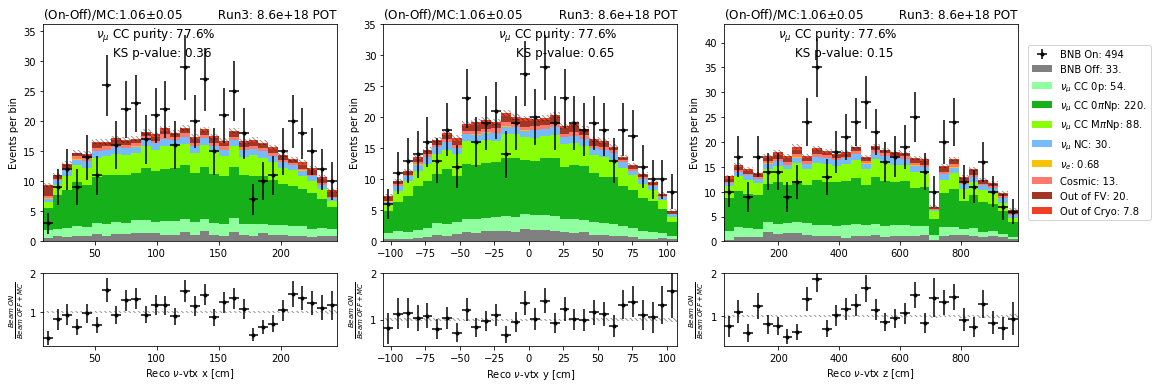

<IPython.core.display.Javascript object>

In [35]:
field = ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
label = [r"Reco $\nu$-vtx x [cm]", r"Reco $\nu$-vtx y [cm]", r"Reco $\nu$-vtx z [cm]"]
legend = [False, False, True]

fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(10 * plotter.gr, 5.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

for i in range(3):
    ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
        ax.T[i],
        field[i],
        label[i],
        N_bins=30,
        x_min=helper.fid_box[i][0],
        x_max=helper.fid_box[i][1],
        query="numuccinc",
        legend=legend[i],
        title_str=title_str.split("NE")[-1],
        kind="cat",
        y_max_scaler=1.25,
    )

    ax[0][i].text(
        ax[0][i].get_xlim()[1] * 0.6,
        ax[0][i].get_ylim()[1] * 0.85,
        r"$\nu_\mu$"
        + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
        horizontalalignment="right",
        fontsize=12,
    )


fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_recovtx_run{}.pdf".format(run), bbox_inches="tight"
)

In [36]:
# Fidvol ratio:
fidvol_vtx_old = [10, 10, 10, 10, 10, 50]
fidvol_vtx_new = [5, 5, 6, 6, 20, 50]

fv_old = 1
fv_new = 1

for i in range(3):
    fv_old *= (helper.upper[i] - fidvol_vtx_old[2 * i]) - (
        helper.lower[i] + fidvol_vtx_old[2 * i + 1]
    )
    fv_new *= (helper.upper[i] - fidvol_vtx_new[2 * i]) - (
        helper.lower[i] + fidvol_vtx_new[2 * i + 1]
    )

# Marco
fv_marco = (233 - 70) * (256.35 - 24) * (1036.8 - 25 - 100 - 85)

print(fv_new / fv_marco)
print(fv_new / fv_old)

1.6809342754712184
1.0703864950625397


<IPython.core.display.Javascript object>

# Done

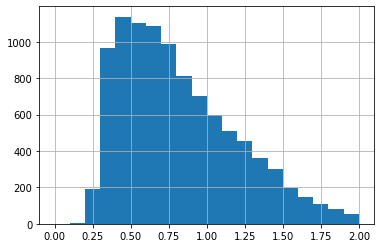

<IPython.core.display.Javascript object>

In [37]:
# Giusseppes request for true energy of calo energy
data["nu"]["daughters"].query("numuccinc & NeutrinoEnergy2<250")["nu_e"].hist(
    bins=20, range=(0, 2)
)

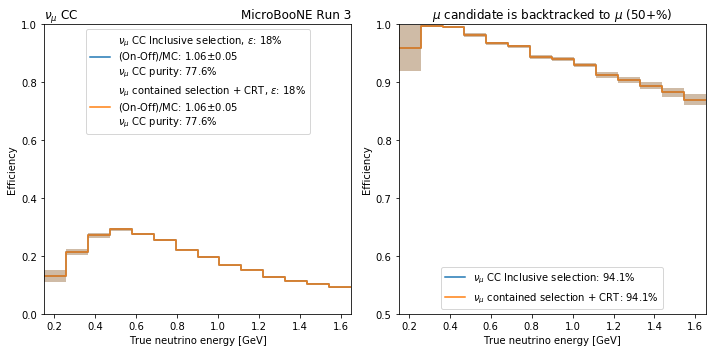

<IPython.core.display.Javascript object>

In [38]:
# eff per mode
field = "nu_e"
x_min = 0.15
x_max = 1.65
n_bins = 15
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
labs = [r"$\nu_\mu$ CC Inclusive selection", r"$\nu_\mu$ contained selection + CRT"]


for q_s, lab in zip(["numuccinc", "numuccinc_crt"], labs):
    # get purity and ratio
    ratio, purity = plotter.get_ratio_and_purity(q_s)

    num = data["nu"]["daughters"].query("category>29 & category<33").query(q_s)[field]
    den = nu_df.query("category>29 & category<33")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)["weightSplineTimesTune"]
    )
    den_w = nu_df.query("category>29 & category<33")["weightSplineTimesTune"]

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[0].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[0].step(
        edges,
        eff,
        where="post",
        label=r"{}, $\varepsilon$: {:.0%}".format(lab, sum(num_w) / sum(den_w))
        + "\n"
        + r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
        + "\n"
        + r"$\nu_\mu$ CC purity: {:.1%}".format(purity),
    )
    ax[0].set_title(r"$\nu_\mu$ CC", loc="left")
    ax[0].set_title("MicroBooNE Run 3", loc="right")
    ax[0].set_xlabel("True neutrino energy [GeV]")
    ax[0].set_ylabel("Efficiency")
    ax[0].set_ylim(0, 1)
    ax[0].set_xlim(x_min, x_max)
    ax[0].legend(loc="upper center")

    num = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)
        .query("abs(backtracked_pdg)==13")[field]
    )
    den = data["nu"]["daughters"].query("category>29 & category<33").query(q_s)[field]

    num_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)
        .query("abs(backtracked_pdg)==13")["weightSplineTimesTune"]
    )
    den_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)["weightSplineTimesTune"]
    )

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[1].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[1].step(
        edges,
        eff,
        where="post",
        label="{}: {:.1%}".format(lab, sum(num_w) / sum(den_w)),
    )
    ax[1].set_title(r"$\mu$ candidate is backtracked to $\mu$ (50+%)")
    ax[1].set_xlabel("True neutrino energy [GeV]")
    ax[1].set_ylabel("Efficiency")
    ax[1].set_ylim(0.5, 1)
    ax[1].set_xlim(x_min, x_max)
    ax[1].legend(loc="lower center")

fig.tight_layout()
fig.savefig(output_dir + "numu_muon_purity_run{}.pdf".format(run), bbox_inches="tight")

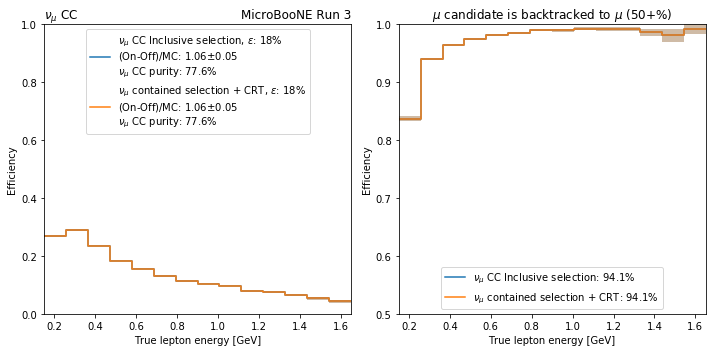

<IPython.core.display.Javascript object>

In [39]:
# eff per mode
field = "lep_e"
x_min = 0.15
x_max = 1.65
n_bins = 15
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
labs = [r"$\nu_\mu$ CC Inclusive selection", r"$\nu_\mu$ contained selection + CRT"]


for q_s, lab in zip(["numuccinc", "numuccinc_crt"], labs):
    # get purity and ratio
    ratio, purity = plotter.get_ratio_and_purity(q_s)

    num = data["nu"]["daughters"].query("category>29 & category<33").query(q_s)[field]
    den = nu_df.query("category>29 & category<33")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)["weightSplineTimesTune"]
    )
    den_w = nu_df.query("category>29 & category<33")["weightSplineTimesTune"]

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[0].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[0].step(
        edges,
        eff,
        where="post",
        label=r"{}, $\varepsilon$: {:.0%}".format(lab, sum(num_w) / sum(den_w))
        + "\n"
        + r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
        + "\n"
        + r"$\nu_\mu$ CC purity: {:.1%}".format(purity),
    )
    ax[0].set_title(r"$\nu_\mu$ CC", loc="left")
    ax[0].set_title("MicroBooNE Run 3", loc="right")
    ax[0].set_xlabel("True lepton energy [GeV]")
    ax[0].set_ylabel("Efficiency")
    ax[0].set_ylim(0, 1)
    ax[0].set_xlim(x_min, x_max)
    ax[0].legend(loc="upper center")

    num = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)
        .query("abs(backtracked_pdg)==13")[field]
    )
    den = data["nu"]["daughters"].query("category>29 & category<33").query(q_s)[field]

    num_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)
        .query("abs(backtracked_pdg)==13")["weightSplineTimesTune"]
    )
    den_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)["weightSplineTimesTune"]
    )

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[1].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[1].step(
        edges,
        eff,
        where="post",
        label="{}: {:.1%}".format(lab, sum(num_w) / sum(den_w)),
    )
    ax[1].set_title(r"$\mu$ candidate is backtracked to $\mu$ (50+%)")
    ax[1].set_xlabel("True lepton energy [GeV]")
    ax[1].set_ylabel("Efficiency")
    ax[1].set_ylim(0.5, 1)
    ax[1].set_xlim(x_min, x_max)
    ax[1].legend(loc="lower center")

fig.tight_layout()
fig.savefig(
    output_dir + "numu_muon_lepe_purity_run{}.pdf".format(run), bbox_inches="tight"
)

In [40]:
print(
    data["nu"]["daughters"]
    .query("category>29 & category<33")
    .query("numuccinc_crt")["backtracked_pdg"]
    .abs()
    .value_counts()
)
print(
    data["nu"]["daughters"]
    .query("category>29 & category<33")
    .query("numuccinc")["backtracked_pdg"]
    .abs()
    .value_counts()
)

13      41869
211      2157
2212      579
0         411
22         23
321         4
Name: backtracked_pdg, dtype: int64
13      41869
211      2157
2212      579
0         411
22         23
321         4
Name: backtracked_pdg, dtype: int64


<IPython.core.display.Javascript object>

In [41]:
data["nu"]["daughters"]["mu_cand"] = data["nu"]["daughters"].eval(q_muon_select)
sums = (
    data["nu"]["daughters"]
    .query("category>29 & category<33")
    .query(
        "reco_fid_vol & CosmicIP>20 & slpdg==14 & topological_score>0.1 & all_start_contained"
    )["mu_cand"]
    .groupby("event")
    .transform(sum)
)
print(sums.value_counts() / len(sums) * 100)

1.0    71.459513
2.0    17.701975
0.0     9.018552
3.0     1.678636
4.0     0.139253
5.0     0.002072
Name: mu_cand, dtype: float64


<IPython.core.display.Javascript object>


Calo Energy
0.2 	 0.2087324 	 [-0.10681168 -0.05135212  0.0317314 ] 	 0.0692715391516685
0.3 	 0.25687748 	 [-0.15795829 -0.06800376  0.02432294] 	 0.09114061892032621
0.4 	 0.32197505 	 [-0.20473976 -0.07548015  0.02311161] 	 0.11392568722367288
0.5 	 0.3882336 	 [-0.27229936 -0.09157491  0.02662616] 	 0.14946276247501372
0.6 	 0.45068324 	 [-0.32836913 -0.10760741  0.02988802] 	 0.17912857308983804
0.6 	 0.49708182 	 [-0.38523223 -0.14384267  0.02651755] 	 0.20587489008903503
0.7 	 0.5470821 	 [-0.45351467 -0.17284775  0.02601083] 	 0.23976274877786632
0.8 	 0.60188925 	 [-0.49886003 -0.19629085  0.03751962] 	 0.26818982660770413
0.9 	 0.6534903 	 [-0.56636804 -0.22667611  0.04156658] 	 0.30396731197834015
1.0 	 0.70755816 	 [-0.62123747 -0.25103042  0.03974365] 	 0.33049056380987163

Range Energy
0.2 	 0.2136087715625763 	 [-0.08896503 -0.0454044   0.07141111] 	 0.08018807214684782
0.3 	 0.2774384990334511 	 [-0.12746222 -0.04898969  0.05343843] 	 0.09045032430440186
0.4 	 0.346668

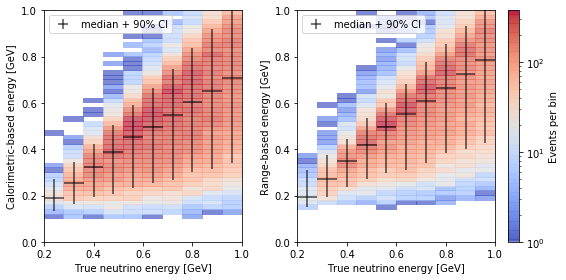

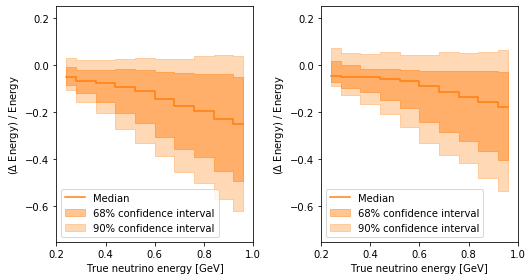

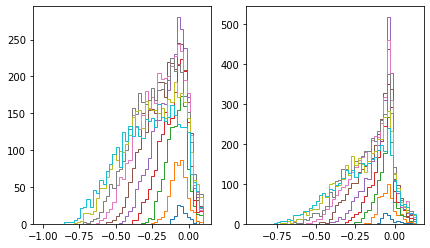

<IPython.core.display.Javascript object>

In [50]:
daughters = (
    data["nu"]["daughters"].query("numuccinc").query("category>29 & category<33")
)

fig, ax = plt.subplots(ncols=2, figsize=(8, 4), gridspec_kw={"width_ratios": [4, 5]})
fig_res, ax_res = plt.subplots(ncols=2, figsize=(7.5, 4))
fig2, ax2 = plt.subplots(ncols=2, figsize=(7, 4))
n_x = 10
n_y = 50

print("\nCalo Energy")
y_min = 0.200
y_max = 1
fld_mc, fld_reco = "nu_e", "NeutrinoEnergy2/1000+0.106"
h, x_edges, y_edges, im = ax[0].hist2d(
    daughters.eval(fld_mc),
    daughters.eval(fld_reco),
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((y_min, y_max), (0, y_max)),
)
ax[0].set_xlabel("True neutrino energy [GeV]")
ax[0].set_ylabel("Calorimetric-based energy [GeV]")
mids, mean, err, quants = getResolution(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, ax2[0]
)
ax[0].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 90% CI",
    alpha=0.7,
)
ax[0].legend(loc="upper left")

ax_res[0].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[0].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[0].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[0].set_xlabel("True neutrino energy [GeV]")
ax_res[0].set_ylabel(r"($\Delta$ Energy) / Energy")
ax_res[0].set_xlim(y_min, y_max)
ax_res[0].set_ylim(-0.75, 0.25)
ax_res[0].legend(loc="lower left")

print("\nRange Energy")
y_min = 0.200
y_max = 1
fld_mc, fld_reco = "nu_e", "range_based_tot_energy"
h, x_edges, y_edges, im = ax[1].hist2d(
    daughters.eval(fld_mc),
    daughters.eval(fld_reco),
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((y_min, y_max), (0, y_max)),
)
ax[1].set_xlabel("True neutrino energy [GeV]")
ax[1].set_ylabel("Range-based energy [GeV]")
mids, mean, err, quants = getResolution(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, ax2[1]
)
ax[1].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 90% CI",
    alpha=0.7,
)
ax[1].legend(loc="upper left")

ax_res[1].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[1].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[1].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[1].set_xlabel("True neutrino energy [GeV]")
ax_res[1].set_ylabel(r"($\Delta$ Energy) / Energy")
ax_res[1].set_xlim(y_min, y_max)
ax_res[1].set_ylim(-0.75, 0.25)
ax_res[1].legend(loc="lower left")


clb = fig.colorbar(im, ax=ax[1])
clb.set_label("Events per bin", rotation=90)
fig.tight_layout()
fig.savefig(output_dir + "resolution.pdf")
fig_res.tight_layout()
fig_res.savefig(output_dir + "resolution_errors.pdf")

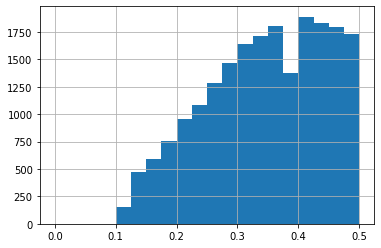

<IPython.core.display.Javascript object>

In [43]:
daughters["trk_energy_proton_v"].hist(bins=20, range=(0, 0.5))